# Programming Assignment

## VAE for the CelebA dataset

### Instructions
In this programming assignment, you will implement the variational autoencoder algorithm for an image dataset of celebrity faces. You will use the trained encoder and decoder networks to reconstruct and generate images. You will also see how the latent space encodes high-level information about the images.

Some code cells are provided for you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the Submit Assignment button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Concatenate, Conv2D, 
                                     UpSampling2D, BatchNormalization)
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# If you would like to make further imports from tensorflow, add them here



![CelebA overview image](data/celeba.png)

#### The Large-scale CelebFaces Attributes (CelebA) Dataset

For this assignment you will use a subset of the CelebFaces Attributes (CelebA) dataset. The full dataset contains over 200K images CelebA contains thousands of colour images of the faces of celebrities, together with tagged attributes such as 'Smiling', 'Wearing glasses', or 'Wearing lipstick'. It also contains information about bounding boxes and facial part localisation. CelebA is a popular dataset that is commonly used for face attribute recognition, face detection, landmark (or facial part) localization, and face editing & synthesis. 

* Z. Liu, P. Luo, X. Wang, and X. Tang. "Deep Learning Face Attributes in the Wild", Proceedings of International Conference on Computer Vision (ICCV), 2015.

You can read about the dataset in more detail [here](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

Your goal is to implement the variational autoencoder algorithm for a subset of the CelebA dataset. For practical reasons we will keep the dataset and the network size relatively small.

#### Load the dataset

The following functions will be useful for loading and preprocessing the dataset. The subset you will use for this assignment consists of 10,000 training images, 1000 validation images and 1000 test images. These examples have been chosen to respect the original training/validation/test split of the dataset.

In [2]:
# Function for loading the images

def load_dataset(split):
    train_list_ds = tf.data.Dataset.from_tensor_slices(np.load('./data/{}.npy'.format(split)))
    train_ds = train_list_ds.map(lambda x: (x, x))
    return train_ds

In [3]:
# Load the training, validation and testing datasets splits

train_ds = load_dataset('train')
val_ds = load_dataset('val')
test_ds = load_dataset('test')

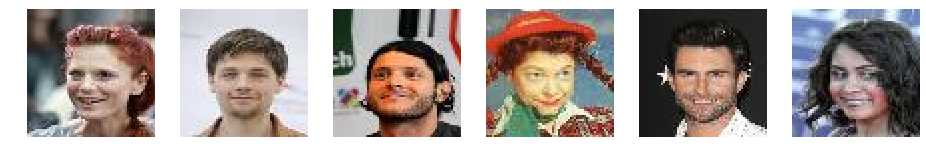

In [4]:
# Display a few examples

n_examples_shown = 6
f, axs = plt.subplots(1, n_examples_shown, figsize=(16, 3))

for j, image in enumerate(train_ds.take(n_examples_shown)):
    axs[j].imshow(image[0])
    axs[j].axis('off')

In [5]:
# Batch the Dataset objects

batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

#### Mixture of Gaussians distribution

We will define a prior distribution that is a mixture of Gaussians. This is a more flexible distribution that is comprised of $K$ separate Gaussians, that are combined together with some weighting assigned to each. 

Recall that the probability density function for a multivariate Gaussian distribution with mean $\mu\in\mathbb{R}^D$ and covariance matrix $\Sigma\in\mathbb{R}^{D\times D}$ is given by

$$
\mathcal{N}(\mathbf{z}; \mathbf{\mu}, \Sigma) = \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}
\exp\left(-\frac{1}{2}(\mathbf{z}-\mathbf{\mu})^T\Sigma^{-1}(\mathbf{z}-\mathbf{\mu})\right).
$$

A mixture of Gaussians with $K$ components defines $K$ Gaussians defined by means $\mathbf{\mu}_k$ and covariance matrices $\Sigma_k$, for $k=1,\ldots,K$. It also requires mixing coefficients $\pi_k$, $k=1,\ldots,K$ with $\sum_{k} \pi_k = 1$. These coefficients define a categorical distribution over the $K$ Gaussian components. To sample an event, we first sample from the categorical distribution, and then again from the corresponding Gaussian component.

The probability density function of the mixture of Gaussians is simply the weighted sum of probability density functions for each Gaussian component:

$$
p(\mathbf{z}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{z}; \mathbf{\mu}_k, \Sigma_k)
$$

#### Define the prior distribution

You should now complete the following function to define the mixture of Gaussians distribution for the prior, for a given number of components and latent space dimension. Each Gaussian component will have a diagonal covariance matrix. This distribution will have fixed mixing coefficients, but trainable means and standard deviations. 

* The function takes `num_modes` (number of components) and `latent_dim` as arguments
* Use the `tfd.MixtureSameFamily` for the prior distribution. Take a look at [the documentation](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily) for this distribution
  * The constructor takes a `mixture_distribution` and `components_distribution` as required arguments
  * The `mixture_distribution` should be fixed to a uniform `tfd.Categorical` distribution, so that $pi_k = 1/K$ in the above equation. This argument will therefore not contain any trainable variables
  * The `components_distribution` should be a `tfd.MultivariateNormalDiag` distribution batch shape equal to `[num_modes]` and event shape equal to `[latent_dim]`. 
    * The `tfd.MultivariateNormalDiag` distribution should have trainable `loc` parameter (initialised with a random normal distribution)  and trainable `scale_diag` parameter (initialised to ones)
    * The `scale_diag` variable should be enforced to be positive using `tfp.util.TransformedVariable` and the `tfb.Softplus` bijection

The function should return the instance of the `tfd.MixtureSameFamily` distribution. 

In [6]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_prior(num_modes, latent_dim):
    """
    This function should create an instance of a MixtureSameFamily distribution 
    according to the above specification. 
    The function takes the num_modes and latent_dim as arguments, which should 
    be used to define the distribution.
    Your function should then return the distribution instance.
    """
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=tf.divide(tf.ones([num_modes]), num_modes)),
        components_distribution = tfd.MultivariateNormalDiag(
            loc = tf.Variable(tf.random.normal([num_modes, latent_dim]),trainable=True, dtype=tf.float32),
            scale_diag = tfp.util.TransformedVariable(initial_value = tf.ones([num_modes, latent_dim]),
                                                      bijector=tfb.Softplus())))
    return prior
    
    

In [7]:
# Run your function to get the prior distribution with 2 components and latent_dim = 50

prior = get_prior(num_modes=2, latent_dim=50)

#### Define the encoder network

We will now define the encoder network as part of the VAE. First, we will define the `KLDivergenceRegularizer` to use in the encoder network to add the KL divergence part of the loss. This should be defined according to the following specification:

* The function takes the `prior_distribution` as an argument
* The function should use the `tfpl.KLDivergenceRegularizer` object to add the KL loss term
* The `tfpl.KLDivergenceRegularizer` should use a weight factor of 1.0 for the KL loss (standard ELBO objective)
* The KL loss cannot be computed exactly, so the `tfpl.KLDivergenceRegularizer` should compute a Monte Carlo approximation by drawing 3 samples from the posterior, and then averaging over the sample and batch axes

Your function should then return the `tfpl.KLDivergenceRegularizer` object.

In [8]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_kl_regularizer(prior_distribution):
    """
    This function should create an instance of the KLDivergenceRegularizer 
    according to the above specification. 
    The function takes the prior_distribution, which should be used to define 
    the distribution.
    Your function should then return the KLDivergenceRegularizer instance.
    """
    return tfpl.KLDivergenceRegularizer(distribution_b = prior_distribution,
                                       use_exact_kl = False,
                                       weight = 1.0,
                                       test_points_fn = lambda q: q.sample(3),
                                       test_points_reduce_axis = (0,1))
    
    

In [9]:
# Run your function to get the KLDivergenceRegularizer

kl_regularizer = get_kl_regularizer(prior)

You should now complete the following function to define the encoder network, according to the following specification:

* The function takes the `latent_dim` and `kl_regularizer` as arguments
* Use the `Sequential` class to define the model
  * The first layer should be a Conv2D layer with 32 filters, 4x4 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding. It should also set the `input_shape` to `(64, 64, 3)`
  * The second layer should be a BatchNormalization layer
  * The third layer should be a Conv2D layer with 64 filters, 4x4 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding
  * The fourth layer should be a BatchNormalization layer
  * The fifth layer should be a Conv2D layer with 128 filters, 4x4 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding
  * The sixth layer should be a BatchNormalization layer
  * The seventh layer should be a Conv2D layer with 256 filters, 4x4 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding
  * The eighth layer should be a BatchNormalization layer
  * The ninth layer should be a Flatten layer
  * The tenth layer should be a Dense layer with no activation function, and the right number of units to parameterise a `MultivariateNormalTriL` layer with event size equal to `latent_dim`
  * The final layer should be a `MultivariateNormalTriL` layer with event size equal to `latent_dim`, and it should use the `kl_regularizer` passed in as the argument as the activity regularizer

In total, your model should have 11 layers.

The function should then return the encoder model.

In [10]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_encoder(latent_dim, kl_regularizer):
    """
    This function should build a CNN encoder model according to the above specification. 
    The function takes latent_dim and kl_regularizer as arguments, which should be
    used to define the model.
    Your function should return the encoder model.
    """
    model = Sequential([
         Conv2D(filters=32, input_shape=(64, 64, 3), kernel_size=(4,4), activation="relu", strides=(2,2), padding="SAME"),
         BatchNormalization(),
         Conv2D(filters=64, kernel_size=(4,4), activation="relu", strides=(2,2), padding="SAME"),
         BatchNormalization(),
         Conv2D(filters=128, kernel_size=(4,4), activation="relu", strides=(2,2), padding="SAME"),
         BatchNormalization(),
         Conv2D(filters=256, kernel_size=(4,4), activation="relu", strides=(2,2), padding="SAME"),
         BatchNormalization(),
         Flatten(),
         Dense(units=tfpl.MultivariateNormalTriL.params_size(latent_dim)),
         tfpl.MultivariateNormalTriL(activity_regularizer=kl_regularizer, event_size=latent_dim)
    ])

    return model
    

In [11]:
# Run your function to get the encoder

encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [12]:
# Print the encoder summary

encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         5

#### Define the decoder network

You should now define the decoder network for the VAE, using the `Sequential` API. This should be a neural network that returns an IndependentBernoulli distribution of `event_shape=(64, 64, 3)`.

* The function takes the `latent_dim` as an argument
* Use the `Sequential` class to define the model
  * The first layer should be a Dense layer with 4096 units and ReLU activation. It should also set the `input_shape` to `(latent_dim,)`
  * The second layer should be a Reshape layer, that reshapes its input to `(4, 4, 256)`
  * The third layer should be an UpSampling2D layer with upsampling factor of `(2, 2)`
  * The fourth layer should be a Conv2D layer with 128 filters, 3x3 kernel size, ReLU activation, and 'SAME' padding
  * The fifth layer should be an UpSampling2D layer with upsampling factor of `(2, 2)`
  * The sixth layer should be a Conv2D layer with 64 filters, 3x3 kernel size, ReLU activation, and 'SAME' padding
  * The seventh layer should be an UpSampling2D layer with upsampling factor of `(2, 2)`
  * The eighth layer should be a Conv2D layer with 32 filters, 3x3 kernel size, ReLU activation, and 'SAME' padding
  * The ninth layer should be an UpSampling2D layer with upsampling factor of `(2, 2)`
  * The tenth layer should be a Conv2D layer with 128 filters, 3x3 kernel size, ReLU activation, and 'SAME' padding
  * The eleventh layer should be a Conv2D layer with 3 filters, 3x3 kernel size, no activation function, and 'SAME' padding
  * The twelfth layer should be a Flatten layer
  * The final layer should be a `IndependentBernoulli` layer with event size equal to `(64, 64, 3)`

In total, your model should have 13 layers.

The function should then return the decoder model.

In [13]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_decoder(latent_dim):
    """
    This function should build a CNN decoder model according to the above specification. 
    The function takes latent_dim as an argument, which should be used to define the model.
    Your function should return the decoder model.
    """
    model = Sequential([
        Dense(units=4096, activation="relu", input_shape=(latent_dim,)),
        Reshape(target_shape=(4, 4, 256)),
        UpSampling2D(size=(2,2)),
        Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="SAME"),
        UpSampling2D(size=(2,2)),
        Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="SAME"),
        UpSampling2D(size=(2,2)),
        Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="SAME"),
        UpSampling2D(size=(2,2)),
        Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="SAME"),
        Conv2D(filters=3, kernel_size=(3,3), padding="SAME"),
        Flatten(),
        tfpl.IndependentBernoulli(event_shape=(64, 64, 3))
])
    
    return model
    

In [14]:
# Run your function to get the decoder

decoder = get_decoder(latent_dim=50)

In [15]:
# Print the decoder summary

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              208896    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         295040    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)       

#### Link the encoder and decoder together

The following cell connects `encoder` and `decoder` to form the end-to-end architecture.

In [16]:
# Connect the encoder and decoder

vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

#### Define the average reconstruction loss

You should now define the reconstruction loss that forms the remaining part of the negative ELBO objective. This function should take a batch of images of shape `(batch_size, 64, 64, 3)` in the first argument, and the output of the decoder after passing the batch of images through `vae` in the second argument. 

The loss should be defined so that it returns
\begin{equation}
    -\frac{1}{n}\sum_{i=1}^n \log p(x_i|z_i)
\end{equation}
where $n$ is the batch size and $z_i$ is sampled from $q(z|x_i)$, the encoding distribution a.k.a. the approximate posterior. The value of this expression is always a scalar.

Expression (1) is, as you know, is an estimate of the (negative of the) batch's average expected reconstruction loss:

\begin{equation}
    -\frac{1}{n}\sum_{i=1}^n \mathrm{E}_{Z\sim q(z|x_i)}\big[\log p(x_i|Z)\big]
\end{equation}

_Hints_ : 
- _You may find the `log_prob` method of the decoding distribution helpful._
- _The code you add does not need to be more than one line._

In [17]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def reconstruction_loss(batch_of_images, decoding_dist):
    """
    This function should compute and return the average expected reconstruction loss,
    as defined above.
    The function takes batch_of_images (Tensor containing a batch of input images to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return - tf.reduce_mean(decoding_dist.log_prob(batch_of_images))
    
    

#### Compile and fit the model

It's now time to compile and train the model. This may take some time, so as an alternative, you can also load a pre-trained model below if you wish. To train your own model, it is recommended to make use of the accelerator hardware available on Colab.

In [18]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [19]:
# EITHER... compile and fit the model

vae.fit(train_ds, validation_data=val_ds, epochs=10)

Train for 313 steps, validate for 32 steps
Epoch 1/10
  3/313 [..............................] - ETA: 47:40 - loss: 8479.9766 

KeyboardInterrupt: 

In [20]:
# OR... load the pre-trained model

ckpt = tf.train.Checkpoint(model=vae)
ckpt.restore(tf.train.latest_checkpoint('./model'))


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7fa5c729fe10> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa55be87160>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa5c75b2898> and <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7fa5c729fc50>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa55be92160> and <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7fa55be92208>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa55be92550> and <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7fa55be92470>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutiona

In [21]:
# Evaluate the model on the test set

test_loss = vae.evaluate(test_ds)
print("Test loss: {}".format(test_loss))

32/32 [==============================] - 44s 1s/step - loss: 6163.2388
Test loss: 6163.238754272461


#### Compute reconstructions of test images

We will now take a look at some image reconstructions from the encoder-decoder architecture.

You should complete the following function, that uses `encoder` and `decoder` to reconstruct images from the test dataset. This function takes the encoder, decoder and a Tensor batch of test images as arguments. The function should be completed according to the following specification:

* Get the mean of the encoding distributions from passing the batch of images into the encoder
* Pass these latent vectors through the decoder to get the output distribution

Your function should then return the mean of the output distribution, which will be a Tensor of shape `(batch_size, 64, 64, 3)`.

In [22]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def reconstruct(encoder, decoder, batch_of_images):
    """
    This function should compute reconstructions of the batch_of_images according
    to the above instructions.
    The function takes the encoder, decoder and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    return decoder(encoder(batch_of_images).mean()).mean()    
    
    

In [23]:
# Run your function to compute reconstructions of random samples from the test dataset

n_reconstructions = 7
num_test_files = np.load('./data/test.npy').shape[0]
test_ds_for_reconstructions = load_dataset('test')
for all_test_images, _ in test_ds_for_reconstructions.batch(num_test_files).take(1):
    all_test_images_np = all_test_images.numpy()
example_images = all_test_images_np[np.random.choice(num_test_files, n_reconstructions, replace=False)]

reconstructions = reconstruct(encoder, decoder, example_images).numpy()

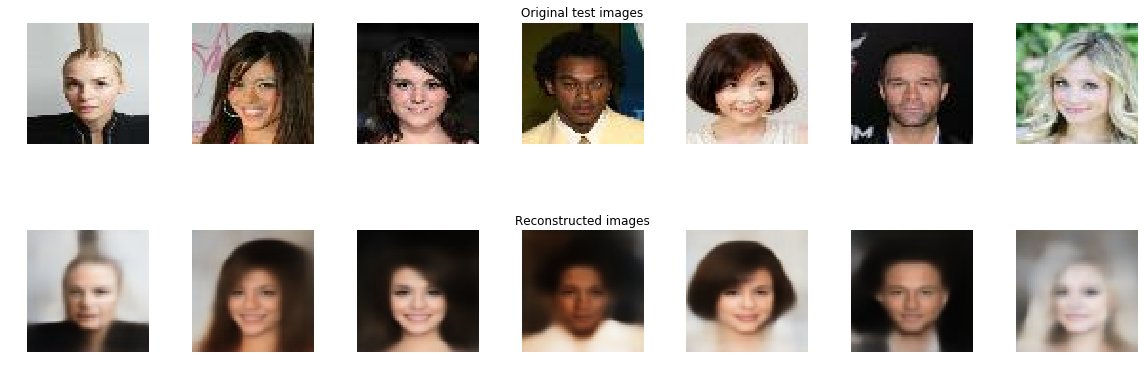

In [24]:
# Plot the reconstructions

f, axs = plt.subplots(2, n_reconstructions, figsize=(16, 6))
axs[0, n_reconstructions // 2].set_title("Original test images")
axs[1, n_reconstructions // 2].set_title("Reconstructed images")
for j in range(n_reconstructions):
    axs[0, j].imshow(example_images[j])
    axs[1, j].imshow(reconstructions[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')
    
plt.tight_layout();

#### Sample new images from the generative model

Now we will sample from the generative model; that is, first sample latent vectors from the prior, and then decode those latent vectors with the decoder.

You should complete the following function to generate new images. This function takes the prior distribution and decoder network as arguments, as well as the number of samples to generate. This function should be completed according to the following:

* Sample a batch of `n_samples` images from the prior distribution, to obtain a latent vector Tensor of shape `(n_samples, 50)`
* Pass this batch of latent vectors through the decoder, to obtain an Independent Bernoulli distribution with batch shape equal to `[n_samples]` and event shape equal to `[64, 64, 3]`.

The function should then return the mean of the Bernoulli distribution, which will be a Tensor of shape `(n_samples, 64, 64, 3)`.

In [25]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def generate_images(prior, decoder, n_samples):
    """
    This function should compute generate new samples of images from the generative model,
    according to the above instructions.
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the images.
    The function should then return the batch of generated images.
    """
    embeddings = prior.sample(n_samples)
    
    return decoder(embeddings).mean().numpy()
    
    

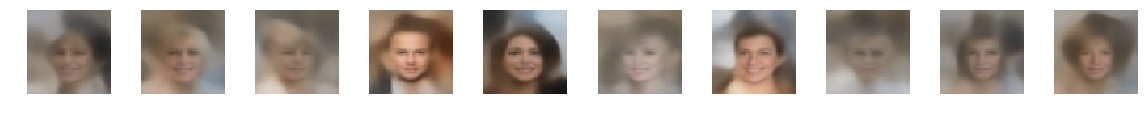

In [26]:
# Run your function to generate new images

n_samples = 10
sampled_images = generate_images(prior, decoder, n_samples)

f, axs = plt.subplots(1, n_samples, figsize=(16, 6))

for j in range(n_samples):
    axs[j].imshow(sampled_images[j])
    axs[j].axis('off')
    
plt.tight_layout();

### Modify generations with attribute vector

This final section is ungraded, but you will hopefully find it to be an interesting extension. We will see how the latent space encodes high-level information about the images, even though it has not been trained with any information apart from the images themselves.

As mentioned in the introduction, each image in the CelebA dataset is labelled according to the attributes of the person pictured.

Run the cells below to load these labels, along with a subset of the training data.

In [27]:
# Function to load labels and images as a numpy array

def load_labels_and_image_arrays(split):
    dataset = load_dataset(split)
    num_files = np.load('./data/{}.npy'.format(split)).shape[0]
    
    for all_images, _ in dataset.batch(num_files).take(1):
        all_images_np = all_images.numpy()

    labels = pd.read_csv('./data/list_attr_celeba_subset.csv')
    files = np.load('./data/{}.npy')
    labels = labels[labels['image_id'].isin(files)]
    return labels, all_images_np

In [28]:
# Load labels in a pandas DataFrame, training_subset is a numpy array

train_labels, training_subset = load_labels_and_image_arrays('train')

FileNotFoundError: [Errno 2] No such file or directory: './data/{}.npy'

In [ ]:
# List the attributes contained in the DataFrame

train_labels.columns[2:]

Each image is labelled with a binary indicator (1 is True, -1 is False) according to whether it possesses the attribute. 

In [ ]:
# View a sample from the labels data

train_labels.sample(5)

In [ ]:
# Select an attribute

attribute = 'Smiling'

In [ ]:
# Separate the images into those that have the attribute, and those that don't

attribute_mask = (train_labels[attribute] == 1)
images_with_attribute = training_subset[attribute_mask]

not_attribute_mask = (train_labels[attribute] == -1)
images_without_attribute = training_subset[not_attribute_mask]

#### Get the 'attribute vector'

We will now encode each of the images that have the chosen attribute into the latent space by passing them through the encoder. We then average the latent codes obtained for all of these images to obtain a single latent code.

We then do the same for the images that do not have the chosen attribute. This gives an average latent code for images with the attribute, and an average latent code for images without the attribute. Intuitively speaking, the difference between these two vectors then gives us the 'direction' in latent space that corresponds to the presence of the attribute.

In [ ]:
# Encode the images with and without the chosen attribute

encoded_images_with_attribute = encoder(images_with_attribute)
encoded_images_without_attribute = encoder(images_without_attribute)

In [ ]:
# Average the latent vectors for each batch of encodings

mean_encoded_images_with_attribute = tf.reduce_mean(encoded_images_with_attribute.mean(), 
                                                    axis=0, keepdims=True)
mean_encoded_images_without_attribute = tf.reduce_mean(encoded_images_without_attribute.mean(), 
                                                    axis=0, keepdims=True)

In [ ]:
# Get the attribute vector

attribute_vector = mean_encoded_images_with_attribute -  mean_encoded_images_without_attribute

We can view this attribute vector by decoding it:

In [ ]:
# Display the decoded attribute vector

decoded_a = decoder(attribute_vector).mean()
plt.imshow(decoded_a.numpy().squeeze())
plt.axis('off');

#### Modify reconstructions using the attribute vector

We can now use the attribute vector to add the attribute to an image reconstruction, where that attribute wasn't present before. To do this, we can just add the attribute vector to the latent vector encoding of the image, and then decode the result. We can also adjust the strength of the attribute vector by scaling with a multiplicative parameter.

In [ ]:
# Add the attribute vector to a sample of images that don't have the attribute

n_examples = 7
sampled_inx = np.random.choice(images_without_attribute.shape[0], n_examples, replace=False)
sample_images_without_attribute = images_without_attribute[sampled_inx]
sample_images_encodings = encoder(sample_images_without_attribute)
sample_images_reconstructions = decoder(sample_images_encodings).mean()

k = 2.5  # Weighting of attribute vector
modified_sample_images_encodings = sample_images_encodings + (k * attribute_vector)
modified_reconstructions = decoder(modified_sample_images_encodings).mean()

In [ ]:
# Display the original images, their reconstructions, and modified reconstructions

f, axs = plt.subplots(3, n_examples, figsize=(16, 6))
axs[0, n_examples // 2].set_title("Original images")
axs[1, n_examples // 2].set_title("Reconstructed images")
axs[2, n_examples // 2].set_title("Images with added attribute")
for j in range(n_examples):
    axs[0, j].imshow(sample_images_without_attribute[j])
    axs[1, j].imshow(sample_images_reconstructions[j])
    axs[2, j].imshow(modified_reconstructions[j])
    for ax in axs[:, j]: ax.axis('off')
    
plt.tight_layout();

You could also try removing the attribute from images that possess the attribute, or experiment with a different attribute.

---

Congratulations for completing this programming assignment! You're now ready to move on to the capstone project for this course.